<a href="https://colab.research.google.com/github/mohsenazade/Data-Mining-Exercises/blob/main/mohsen_azadeh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Library

In [92]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
import nltk
import spacy

from nltk.corpus import sentiwordnet as swn
import re
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from collections import defaultdict



nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('sentiwordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


True

In [93]:
#import other lists of stopwords
with open('/content/StopWords_GenericLong.txt', 'r') as f:
 x_gl = f.readlines()
with open('/content/StopWords_Names.txt', 'r') as f:
 x_n = f.readlines()
with open('/content/StopWords_DatesandNumbers.txt', 'r') as f:
 x_d = f.readlines()
#import nltk stopwords
stopwords = nltk.corpus.stopwords.words('english')#combine all stopwords
[stopwords.append(x.rstrip()) for x in x_gl]
[stopwords.append(x.rstrip()) for x in x_n]
[stopwords.append(x.rstrip()) for x in x_d]
#change all stopwords into lowercase
stopwords_lower = [s.lower() for s in stopwords]

#DataSet

#####***Load Data***

In [94]:
# Loading csv file
df =pd.read_csv('/content/BTCUSDnews_Mohsen_Azadeh_Label.csv', usecols=['Label','title','articleBody'],encoding = "ISO-8859-1")
twe=df[['Label','articleBody']]
twe['label']=twe['Label']
twe['totallText']=twe['articleBody']
totall=twe[['label','totallText']]
totall.head(3)

,label,totallText
0,0,Bitcoins price action has been incredibly lac...
1,1,"The United States is in turmoil, and the dolla..."
2,0,An over 300 million active register accounts o...


In [95]:
totall.shape

(855, 2)

#####***Splitting into train and test***

In [96]:
from sklearn.model_selection import train_test_split
totall_train, totall_test, target_train, target_test = train_test_split(totall.totallText,totall.label,test_size = 0.2)

In [97]:
totall_train.shape

(684,)

In [98]:
totall_test.shape

(171,)

In [99]:
totall_train.head(3)

568    Bitcoin price suffered a powerful correction f...
521    Bitcoin price extended its rise above the $10,...
162    Bitcoin is trading in a contracting range abov...
Name: totallText, dtype: object

In [100]:
totall_test.head(3)

87     Bitcoin has seen some of the most boring price...
103    The Chinese stock market has found itself caug...
415    Bitcoin has seemingly entered no man&#8217;s l...
Name: totallText, dtype: object

<Figure size 576x432 with 0 Axes>

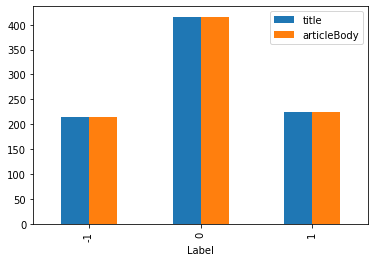

In [101]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Label').count().plot.bar(ylim=0)
plt.show()

#***Text Processing***

#####***A. Cleaning of Raw Data***

In [102]:
def to_lower(word): 
     result = word.lower() 
     return result

In [103]:
def remove_number(word):
    result = re.sub(r'\d+', '', word)
    return result

In [104]:
def remove_mentions(word):       
    result = re.sub(r"@\S+", "", word)       
    return result

In [105]:
def remove_special_characters(word):       
    result = word.translate(str.maketrans(dict.fromkeys(string.punctuation)))    
    return result

In [106]:
def remove_stopwords(word):
    return ' '.join(word for word in i.split() if word not in stopwords_lower)


In [107]:
def remove_whitespace(word):
    result = word.strip()
    return result


In [108]:
def remove_punctuation(word):
    result = re.sub('[^A-Za-z]+', ' ', word)
    return result


In [109]:
def replace_newline(word):
    return word.replace('\n','')

In [110]:
def remove_hyperlink(word):       
    return re.sub(r"http\S+", "", word)

In [111]:
def clean_up_pipeline(sentence):
    cleaning_data = [remove_hyperlink,
                      replace_newline,
                      to_lower,
                      remove_number,
                      remove_punctuation,
                      remove_whitespace]
    for func in cleaning_data:
        
        sentence = func(sentence)
    return sentence


In [112]:
totall_train = totall_train.apply(clean_up_pipeline)
print(totall_train)


568    bitcoin price suffered a powerful correction f...
521    bitcoin price extended its rise above the resi...
162    bitcoin is trading in a contracting range abov...
804    an important fundamental health signal of the ...
372    things have been looking up for bitcoin the cr...
                             ...                        
379    bitcoin has been surging higher over recent we...
158    with bitcoin trading sideways for so long and ...
598    bitcoin s price action has been flashing warni...
76     peter schiff the ceo of euro pacific capital s...
275    bitcoin s price is currently flashing signs of...
Name: totallText, Length: 684, dtype: object


#####***B. Tokenization***

In [113]:
from nltk.tokenize import word_tokenize
totall_train = totall_train.apply(word_tokenize)
#cleaned_tweets_test = cleaned_tweets_test.apply(word_tokenize)

In [114]:
totall_train.head(3)

568    [bitcoin, price, suffered, a, powerful, correc...
521    [bitcoin, price, extended, its, rise, above, t...
162    [bitcoin, is, trading, in, a, contracting, ran...
Name: totallText, dtype: object

#####***C. Stemming***

In [115]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text])
totall_train = totall_train.apply(lambda text: stem_words(text))


In [116]:
totall_train.head(3)

568    bitcoin price suffer a power correct from the ...
521    bitcoin price extend it rise abov the resist a...
162    bitcoin is trade in a contract rang abov again...
Name: totallText, dtype: object

#***Word Embedding Techniques***

#####***Word2Vec***

In [117]:
import gensim
tokenize=totall_train.apply(lambda x: x.split())
w2vec_model=gensim.models.Word2Vec(tokenize,min_count = 1, size = 100, window = 5, sg = 1)
w2vec_model.train(tokenize,total_examples= len(totall_train),epochs=20)

(511460, 739420)

In [118]:
from sklearn.feature_extraction.text import CountVectorizer

In [119]:
bow=CountVectorizer( min_df=2, max_features=1000)
bow.fit(totall_train)
bow_df=bow.transform(totall_train).toarray()

In [120]:
bow_df.shape

(684, 1000)

#####***Model Fitting***

In [121]:
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
import numpy as np
from sklearn.svm import SVC

In [122]:
target_train =np.array(target_train)

In [123]:
from textblob import TextBlob

tresult = [TextBlob(i).sentiment.polarity for i in totall_train]
tpred = [0 if n < 0 else 1 for n in tresult]

#####**Performance Metrics for News Bitcoin Sentiment Analysis**

In [124]:
vec = CountVectorizer() 

X_train_transformed =  vec.fit_transform(totall_train) 

X_test_transformed = vec.transform(totall_test)


In [125]:
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score


clf= MultinomialNB()
clf.fit(X_train_transformed, target_train)

score = clf.score(X_test_transformed, target_test)
print("score of Naive Bayes algo is :\n   " , score)

y_pred = clf.predict(X_test_transformed)
cf_matrix=confusion_matrix(target_test,y_pred)
print(cf_matrix)

print(precision_score(target_test,y_pred,pos_label=1,average='macro'))
print(recall_score(target_test, y_pred, pos_label=1,average='macro') )

print("F1_Score :",f1_score(target_test, y_pred, pos_label=1,average='weighted'))



score of Naive Bayes algo is :
    0.4269005847953216
[[ 6 34  2]
 [ 7 65 11]
 [ 6 38  2]]
0.3078584539206898
0.3231559779490633
F1_Score : 0.35277276649148953


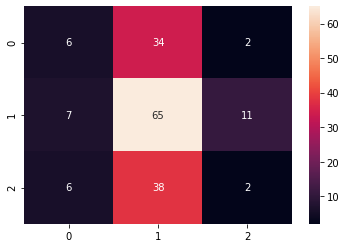

In [126]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

In [127]:
from sklearn.svm import LinearSVC

In [128]:
model = LinearSVC()
#X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train_transformed, target_train)
y_pred = model.predict(X_test_transformed)

score = model.score(X_test_transformed, target_test)
print("score of SVM is :\n   " , score)

y_pred = model.predict(X_test_transformed)
cf_matrix=confusion_matrix(target_test,y_pred)
print(cf_matrix)

print(precision_score(target_test,y_pred,pos_label=1,average='macro'))
print(recall_score(target_test, y_pred, pos_label=1,average='macro') )

print("F1_Score :",f1_score(target_test, y_pred, pos_label=1,average='weighted'))



score of SVM is :
    0.42105263157894735
[[19 13 10]
 [19 44 20]
 [10 27  9]]
0.383470695970696
0.3927178694072356
F1_Score : 0.4164388114036804


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


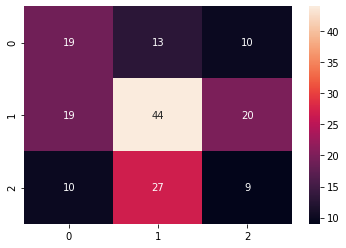

In [129]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)